<a href="https://colab.research.google.com/github/Marcosuff/Marcosuff.github.io/blob/master/nbs/chembl_proteins_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U fastai

     |████████████████████████████████| 358kB 2.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
#export
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from os.path import join
import os
from fastai.tabular.all import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title
#hide
# RUN THIS CELL ONCE TO DOWNLOAD ChEMBL
#!wget -c http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_27/chembl_27_sqlite.tar.gz
#!tar -xvf /content/chembl_27_sqlite.tar.gz

In [3]:
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! bash Anaconda3-2019.10-Linux-x86_64.sh -bfp /usr/local
sys.path.append('/usr/local/lib/python3.7/site-packages')
!conda install -y -c rdkit rdkit

--2020-09-09 18:07:01--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   139MB/s    in 3.6s    

2020-09-09 18:07:05 (140 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37

In [4]:
ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Blog'      # path to your project on Drive

GIT_USERNAME = "Marcosuff" # replace with yours
GIT_REPOSITORY = "Marcosuff.github.io"      # ...nah
GIT_TOKEN = 'dee4192a28a49b4acc3897425086d65cabe8b47f'

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"     # in case we haven't created it already   


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEa3eQvyhBRuestxaE8nehc8M77a2JWS0ugXI645WCHtuMXEGm8s9Q
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/Blog’: File exists


In [5]:
GIT_PATH = "https://dee4192a28a49b4acc3897425086d65cabe8b47f@github.com/Marcosuff/Marcosuff.github.io.git"
!git clone "{GIT_PATH}"

Cloning into 'Marcosuff.github.io'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 187 (delta 86), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (187/187), 22.45 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [6]:
df = pd.read_csv('/content/Marcosuff.github.io/data/chembl27.csv.gz')

In [7]:
df.head()

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score
0,6570,4000.0,IC50,=,5.40,252199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4ccc(Cl)c(C(F)(F)F)c4)CC3)ccc2s1,CHEMBL357278,10483,CHEMBL4632,Enzyme,Oxidoreductase,NaN,8
1,6570,17000.0,IC50,=,4.77,253534,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC3)ccc2s1,CHEMBL357119,10483,CHEMBL4632,Enzyme,Oxidoreductase,NaN,8
2,6570,180.0,IC50,=,6.75,253199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1,CHEMBL152968,10483,CHEMBL4632,Enzyme,Oxidoreductase,NaN,8
3,6570,6000.0,IC50,=,5.22,253199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1,CHEMBL152968,12594,CHEMBL3356,Enzyme,Cytochrome P450,Cytochrome P450 family 1,8
4,6570,37000.0,IC50,=,4.43,253199,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1,CHEMBL152968,17045,CHEMBL340,Enzyme,Cytochrome P450,Cytochrome P450 family 3,8


In [38]:
target_classes = set(df['l2'].astype(str))
gpcr_family = [x for x in target_classes if 'G protein-coupled' in x]
kinase_family = 'Kinase'
protease_family = 'Protease'
ptnf = gpcr_family + [kinase_family, protease_family]
ptnf

['Taste family G protein-coupled receptor',
 'Family A G protein-coupled receptor',
 'Frizzled family G protein-coupled receptor',
 'Family B G protein-coupled receptor',
 'Family C G protein-coupled receptor',
 'Kinase',
 'Protease']

In [39]:
df_subset = df[df['l2'].isin(ptnf)]
print(df_subset.shape)
df_subset.head()

(650411, 14)


,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score
6,7725,29.4,IC50,=,7.53,100708,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CHEMBL305153,50,CHEMBL213,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
7,7725,30.8,IC50,=,7.51,100708,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CHEMBL305153,10031,CHEMBL3373,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
11,8674,19.0,IC50,=,7.72,29412,CCN1CCC[C@H]1CNC(=O)c1c(OC)ccc(C)c1O,CHEMBL23228,14037,CHEMBL339,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
12,2704,9800.0,IC50,=,5.01,97517,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,72,CHEMBL217,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
13,2704,5600.0,IC50,=,5.25,97517,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,130,CHEMBL234,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8


## **EDA**

In [40]:
ic50s = df_subset[df_subset['standard_type']=='IC50']

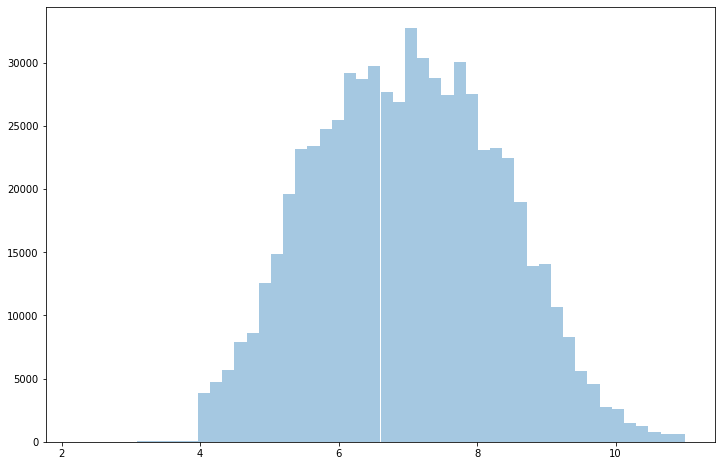

In [41]:
# Distribution of IC50 values
fig = plt.figure(figsize=(12,8))

sns.distplot(a=df_subset['pchembl'].values,kde=False)

Maybe we can select an activity cutoff of 6.5 (~10uM)

In [47]:
df_subset_ic50 = df_subset[(~df_subset['pchembl'].isnull()) & (~df_subset['canonical_smiles'].isnull()) & (df_subset['standard_type']=='IC50') & (df_subset['standard_relation'] == '=')]
np.unique(df_subset_ic50['standard_type'].values),np.unique(df_subset_ic50['standard_relation'].values)

(array(['IC50'], dtype=object), array(['='], dtype=object))

In [48]:
df_subset_ic50.head()

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score
6,7725,29.4,IC50,=,7.53,100708,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CHEMBL305153,50,CHEMBL213,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
7,7725,30.8,IC50,=,7.51,100708,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CHEMBL305153,10031,CHEMBL3373,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
11,8674,19.0,IC50,=,7.72,29412,CCN1CCC[C@H]1CNC(=O)c1c(OC)ccc(C)c1O,CHEMBL23228,14037,CHEMBL339,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
12,2704,9800.0,IC50,=,5.01,97517,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,72,CHEMBL217,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8
13,2704,5600.0,IC50,=,5.25,97517,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,130,CHEMBL234,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8


In [51]:
df_subset_ic50.to_csv('df_subset_ic50.csv',index=False,sep=';')

In [57]:
df_subset_ic50 = pd.read_csv('df_subset_ic50.csv',sep=';')
df_subset_ic50['act'] = np.where(df_subset_ic50['pchembl'].values>=6.5,'Active','Inactive')

In [58]:
df_subset_ic50.head()

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score,act
0,7725,29.4,IC50,=,7.53,100708,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CHEMBL305153,50,CHEMBL213,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8,Active
1,7725,30.8,IC50,=,7.51,100708,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CHEMBL305153,10031,CHEMBL3373,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8,Active
2,8674,19.0,IC50,=,7.72,29412,CCN1CCC[C@H]1CNC(=O)c1c(OC)ccc(C)c1O,CHEMBL23228,14037,CHEMBL339,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8,Active
3,2704,9800.0,IC50,=,5.01,97517,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,72,CHEMBL217,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8,Inactive
4,2704,5600.0,IC50,=,5.25,97517,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,130,CHEMBL234,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),8,Inactive


# Filter targets

We need to pick targets if a good number of Active/Inactive compounds. What a good number would be? Well, I'd say at least 1000 tested compounds.

In [76]:
grouped = df_subset_ic50[['target_chembl_id','l2','chembl_id']].groupby(['l2','target_chembl_id']).count()
grouped

chembl_id
l2                                      target_chembl_id           
Family A G protein-coupled receptor     CHEMBL1075058            15
                                        CHEMBL1075111             2
                                        CHEMBL1075112             2
                                        CHEMBL1075140             2
                                        CHEMBL1075144            47
...                                                             ...
Protease                                CHEMBL6158                2
                                        CHEMBL6159                6
                                        CHEMBL6195                6
Taste family G protein-coupled receptor CHEMBL2034804             5
                                        CHEMBL3309105           149

[1299 rows x 1 columns]

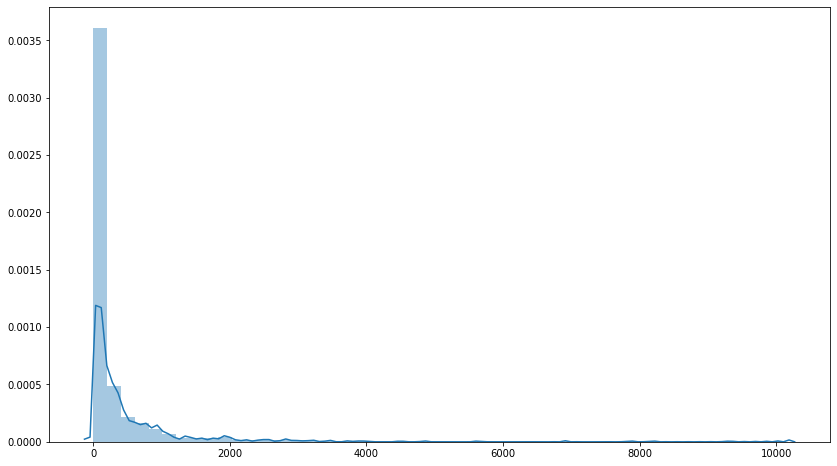

In [79]:
fig= plt.figure(figsize=(14,8))
sns.distplot(a=grouped)

In [80]:
grouped.describe()

,chembl_id
count,1299.000000
mean,285.266359
std,762.005609
min,1.000000
25%,6.000000
50%,36.000000
75%,234.500000
max,10140.000000


# Sanitize SMILES

In [ ]:
#export
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.SaltRemover import SaltRemover as saltremover
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem import AllChem, SanitizeMol
from rdkit import rdBase
from rdkit.Chem import rdmolops
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.info')

_saltremover = saltremover()
_unwanted = Chem.MolFromSmarts('[!#1!#6!#7!#8!#9!#15!#16!#17!#35!#53]')

def _initialiseNeutralisationReactions():
  patts = (
        # Imidazoles
        ('[n+;H]', 'n'),
        # Amines
        ('[N+;!H0]', 'N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]', 'O'),
        # Thiols
        ('[S-;X1]', 'S'),
        #Amidines
        ('[C+](N)', 'C(=N)'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]', 'N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]', 'N'),
        # Tetrazoles
        ('[n-]', '[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]', 'S'),
        # Amides
        ('[$([N-]C=O)]', 'N'),
    )
  return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

def neutralise(mol,reactions=None):
  reactions = _initialiseNeutralisationReactions()
  replaced = False
  for i,(reactant, product) in enumerate(reactions):
    while mol.HasSubstructMatch(reactant):
      replaced = True
      rms = AllChem.ReplaceSubstructs(mol, reactant, product)
      mol = rms[0]

  if replaced:
    rdmolops.Cleanup(mol)
    rdmolops.SanitizeMol(mol)
    mol = rdmolops.RemoveHs(mol, implicitOnly=False, updateExplicitCount=False, sanitize=True)
    return mol
  else:
    rdmolops.Cleanup(mol)
    rdmolops.SanitizeMol(mol)
    mol = rdmolops.RemoveHs(mol, implicitOnly=False, updateExplicitCount=False, sanitize=True)
    return mol

def _rare_filters(mol):
  if mol:
    cyano_filter = "[C-]#[N+]"
    oh_filter = "[OH+]"
    sulfur_filter = "[SH]"
    sulfur_filter2 = "[SH2]"
    iodine_filter1 = "[IH2]"
    iodine_filter2 = "[I-]"
    iodine_filter3 = "[I+]"

    if not mol.HasSubstructMatch(Chem.MolFromSmarts(cyano_filter)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(oh_filter)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(sulfur_filter2)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(iodine_filter1)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(iodine_filter2)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(iodine_filter3)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(sulfur_filter)):
      return mol

class MoleculeDataset():
  def __init__(self,fname:str,smiles_column:str='canonical_smiles',activity_column = None, sep:str='\t',chunkfy=False,chunksize=5000):
    chunkfy_values = [True, False]
    
    self.fname = os.path.basename(fname).split('.')[0]
    self.chunksize = chunksize
    self.chunkfy = chunkfy

    if self.chunkfy == True: 
      self.df = pd.read_csv(fname,chunksize=self.chunksize,sep=sep)

    elif self.chunkfy == False:
      self.df = pd.read_csv(fname,sep=sep)
    else:
      raise ValueError('Invalid option: Choose if you want to split the data into chunks. Expected value: True or False')

    self.smiles_column = smiles_column
    self.activity_column = activity_column
    self.sep = sep
    self.sequential = True

  def add_mol_column(self, smiles):
    if type(smiles) == str and smiles != '':
      
      mol = Chem.MolFromSmiles(smiles)
      return mol
    else:
      return None

  def remove_unwanted(self,mol):
    if not mol.HasSubstructMatch(_unwanted) and (sum([atom.GetIsotope() for atom in mol.GetAtoms()])==0):
      return mol

  def _remove_salts(self,mol):
    mol = _saltremover.StripMol(mol, dontRemoveEverything=True)
    mol = _saltremover.StripMol(mol, dontRemoveEverything=True)
    mol = rdmolops.RemoveHs(mol, implicitOnly=False, updateExplicitCount=False, sanitize=True)
    mol = self._getlargestFragment(mol)
    return mol

  def _getlargestFragment(self, mol):
    frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=True)
    maxmol = None
    for mol in frags:
        if mol is None:
            continue
        if maxmol is None:
            maxmol = mol
        if maxmol.GetNumHeavyAtoms() < mol.GetNumHeavyAtoms():
            maxmol = mol
    return maxmol

  def is_valid(self, mol, min_heavy_atoms = 10, max_heavy_atoms = 50):
    if mol:
      return _rare_filters(mol) if min_heavy_atoms < mol.GetNumHeavyAtoms() < max_heavy_atoms else None
    return None

  def canonical_smiles(self, mol):
    if mol:
      return Chem.MolToSmiles(mol, isomericSmiles = True) if mol.GetNumHeavyAtoms()>0 else print(type(mol))
    else:
      return None

  def process_data(self, c):
    c = c.loc[~c[self.smiles_column].isnull()]

    c['mol'] = c[self.smiles_column].apply(self.add_mol_column)
    c = c.loc[~c['mol'].isnull()]

    c['mol'] = c['mol'].apply(self.remove_unwanted)
    c['mol'] = c['mol'].apply(_rare_filters)
    c = c.loc[~c['mol'].isnull()]
      
    c['mol'] = c['mol'].apply(self._remove_salts)
    c['mol'] = c['mol'].apply(neutralise)
    c['mol'] = c['mol'].apply(self.is_valid)
    c = c.loc[~c['mol'].isnull()]  
    
    c['processed_smiles'] = c['mol'].apply(self.canonical_smiles)
    c = c.loc[~c['processed_smiles'].isnull()]
    c.drop_duplicates(subset='processed_smiles',inplace=True)
    return c

  def sanitize_data(self):
    if self.chunkfy == True:
      i = 0
      chunks =[]
      for chunk in self.df: chunks.append(self.process_data(chunk))
      return pd.concat(chunks,axis=0)
    else:
      processed_df = self.process_data(self.df)
      return processed_df

In [ ]:
fxa_ic50.to_csv('fxa_ic50.csv',index=False,sep=';')

In [ ]:
dataset = MoleculeDataset(fname='/content/fxa_ic50.csv',smiles_column='canonical_smiles',activity_column='pchembl',sep=';')

In [ ]:
fxa_ic50_processed = dataset.sanitize_data()

In [ ]:
fxa_ic50_processed.head()

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score,act,mol,processed_smiles
0,3476,44.4,IC50,=,7.35,192068,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc3ccccc3n2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL117716,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,<rdkit.Chem.rdchem.Mol object at 0x7f3fb55a39e0>,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc3ccccc3n2)NS(=O)(=O)Cc2ccccc2)C1O
1,6512,180.0,IC50,=,6.75,203908,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1-n1ccccc1=O,CHEMBL337921,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,<rdkit.Chem.rdchem.Mol object at 0x7f3fb55a3990>,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1-n1ccccc1=O
2,6512,120.0,IC50,=,6.92,204329,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1N1CCOCC1=O,CHEMBL340500,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,<rdkit.Chem.rdchem.Mol object at 0x7f3fb55a3940>,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1N1CCOCC1=O
3,3476,311.0,IC50,=,6.51,192044,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CNC(=O)c2cnccn2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL117721,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,<rdkit.Chem.rdchem.Mol object at 0x7f3fb55a38a0>,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CNC(=O)c2cnccn2)NS(=O)(=O)Cc2ccccc2)C1O
4,3476,6.1,IC50,=,8.21,191486,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc(O)nc2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL331807,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,<rdkit.Chem.rdchem.Mol object at 0x7f3fb55a3850>,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc(O)nc2)NS(=O)(=O)Cc2ccccc2)C1O


In [ ]:
fxa_ic50_processed.drop('mol',axis=1,inplace=True)

In [ ]:
fxa_ic50_processed.to_csv('/content/Marcosuff.github.io/data/fxa_ic50_processed.csv',index=False,sep=';')

# Compute Fingerprints (Features)

We are going to use Morgan Circular fingerprints implemented in RDKit:

`AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=1024)`

In [ ]:
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, DataStructs

In [ ]:
def getfp(mol):
  '''Returns Morgan fingerprints for a molecule'''
  arr = np.zeros((0,), dtype=np.int8)
  fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(mol),radius=2,nBits=1024)
  DataStructs.ConvertToNumpyArray(fp,arr)
  return arr.reshape(1,1024)
*fps, = map(getfp,list(fxa_ic50['canonical_smiles'].values))

In [ ]:
cat_names = ['fp{}'.format(x) for x in range(1024)]
fps_df = pd.DataFrame(np.concatenate(fps, axis=0),columns=cat_names)

In [ ]:
fps_df.head()

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,fp37,fp38,fp39,...,fp984,fp985,fp986,fp987,fp988,fp989,fp990,fp991,fp992,fp993,fp994,fp995,fp996,fp997,fp998,fp999,fp1000,fp1001,fp1002,fp1003,fp1004,fp1005,fp1006,fp1007,fp1008,fp1009,fp1010,fp1011,fp1012,fp1013,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
fps_df.shape,fxa_ic50.shape

((2891, 1024), (2891, 15))

In [ ]:
fxa_ic50.reset_index(drop=True,inplace=True)
merged_data = pd.concat([fxa_ic50,fps_df],axis = 1)

In [ ]:
merged_data.isnull().any()

doc_id               False
standard_value       False
standard_type        False
standard_relation    False
pchembl              False
                     ...  
fp1019               False
fp1020               False
fp1021               False
fp1022               False
fp1023               False
Length: 1039, dtype: bool

# Create dataloaders

In [ ]:
doc(TabularDataLoaders)

TabularDataLoaders(*loaders, path='.', device=None)
Basic wrapper around several `DataLoader`s with factory methods for tabular data

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
dls = TabularDataLoaders.from_df(df=merged_data,procs=[Categorify],cat_names=cat_names,cont_names=[],
                                 y_names='act',y_block = CategoryBlock)

In [ ]:
dls.show_batch()

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,fp10,fp11,fp12,fp13,fp14,fp15,fp16,fp17,fp18,fp19,fp20,fp21,fp22,fp23,fp24,fp25,fp26,fp27,fp28,fp29,fp30,fp31,fp32,fp33,fp34,fp35,fp36,fp37,fp38,fp39,fp40,fp41,fp42,fp43,fp44,fp45,fp46,fp47,fp48,fp49,fp50,fp51,fp52,fp53,fp54,fp55,fp56,fp57,fp58,fp59,fp60,fp61,fp62,fp63,fp64,fp65,fp66,fp67,fp68,fp69,fp70,fp71,fp72,fp73,fp74,fp75,fp76,fp77,fp78,fp79,fp80,fp81,fp82,fp83,fp84,fp85,fp86,fp87,fp88,fp89,fp90,fp91,fp92,fp93,fp94,fp95,fp96,fp97,fp98,fp99,fp100,fp101,fp102,fp103,fp104,fp105,fp106,fp107,fp108,fp109,fp110,fp111,fp112,fp113,fp114,fp115,fp116,fp117,fp118,fp119,fp120,fp121,fp122,fp123,fp124,fp125,fp126,fp127,fp128,fp129,fp130,fp131,fp132,fp133,fp134,fp135,fp136,fp137,fp138,fp139,fp140,fp141,fp142,fp143,fp144,fp145,fp146,fp147,fp148,fp149,fp150,fp151,fp152,fp153,fp154,fp155,fp156,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166,fp167,fp168,fp169,fp170,fp171,fp172,fp173,fp174,fp175,fp176,fp177,fp178,fp179,fp180,fp181,fp182,fp183,fp184,fp185,fp186,fp187,fp188,fp189,fp190,fp191,fp192,fp193,fp194,fp195,fp196,fp197,fp198,fp199,fp200,fp201,fp202,fp203,fp204,fp205,fp206,fp207,fp208,fp209,fp210,fp211,fp212,fp213,fp214,fp215,fp216,fp217,fp218,fp219,fp220,fp221,fp222,fp223,fp224,fp225,fp226,fp227,fp228,fp229,fp230,fp231,fp232,fp233,fp234,fp235,fp236,fp237,fp238,fp239,fp240,fp241,fp242,fp243,fp244,fp245,fp246,fp247,fp248,fp249,fp250,fp251,fp252,fp253,fp254,fp255,fp256,fp257,fp258,fp259,fp260,fp261,fp262,fp263,fp264,fp265,fp266,fp267,fp268,fp269,fp270,fp271,fp272,fp273,fp274,fp275,fp276,fp277,fp278,fp279,fp280,fp281,fp282,fp283,fp284,fp285,fp286,fp287,fp288,fp289,fp290,fp291,fp292,fp293,fp294,fp295,fp296,fp297,fp298,fp299,fp300,fp301,fp302,fp303,fp304,fp305,fp306,fp307,fp308,fp309,fp310,fp311,fp312,fp313,fp314,fp315,fp316,fp317,fp318,fp319,fp320,fp321,fp322,fp323,fp324,fp325,fp326,fp327,fp328,fp329,fp330,fp331,fp332,fp333,fp334,fp335,fp336,fp337,fp338,fp339,fp340,fp341,fp342,fp343,fp344,fp345,fp346,fp347,fp348,fp349,fp350,fp351,fp352,fp353,fp354,fp355,fp356,fp357,fp358,fp359,fp360,fp361,fp362,fp363,fp364,fp365,fp366,fp367,fp368,fp369,fp370,fp371,fp372,fp373,fp374,fp375,fp376,fp377,fp378,fp379,fp380,fp381,fp382,fp383,fp384,fp385,fp386,fp387,fp388,fp389,fp390,fp391,fp392,fp393,fp394,fp395,fp396,fp397,fp398,fp399,fp400,fp401,fp402,fp403,fp404,fp405,fp406,fp407,fp408,fp409,fp410,fp411,fp412,fp413,fp414,fp415,fp416,fp417,fp418,fp419,fp420,fp421,fp422,fp423,fp424,fp425,fp426,fp427,fp428,fp429,fp430,fp431,fp432,fp433,fp434,fp435,fp436,fp437,fp438,fp439,fp440,fp441,fp442,fp443,fp444,fp445,fp446,fp447,fp448,fp449,fp450,fp451,fp452,fp453,fp454,fp455,fp456,fp457,fp458,fp459,fp460,fp461,fp462,fp463,fp464,fp465,fp466,fp467,fp468,fp469,fp470,fp471,fp472,fp473,fp474,fp475,fp476,fp477,fp478,fp479,fp480,fp481,fp482,fp483,fp484,fp485,fp486,fp487,fp488,fp489,fp490,fp491,fp492,fp493,fp494,fp495,fp496,fp497,fp498,fp499,fp500,fp501,fp502,fp503,fp504,fp505,fp506,fp507,fp508,fp509,fp510,fp511,fp512,fp513,fp514,fp515,fp516,fp517,fp518,fp519,fp520,fp521,fp522,fp523,fp524,fp525,fp526,fp527,fp528,fp529,fp530,fp531,fp532,fp533,fp534,fp535,fp536,fp537,fp538,fp539,fp540,fp541,fp542,fp543,fp544,fp545,fp546,fp547,fp548,fp549,fp550,fp551,fp552,fp553,fp554,fp555,fp556,fp557,fp558,fp559,fp560,fp561,fp562,fp563,fp564,fp565,fp566,fp567,fp568,fp569,fp570,fp571,fp572,fp573,fp574,fp575,fp576,fp577,fp578,fp579,fp580,fp581,fp582,fp583,fp584,fp585,fp586,fp587,fp588,fp589,fp590,fp591,fp592,fp593,fp594,fp595,fp596,fp597,fp598,fp599,fp600,fp601,fp602,fp603,fp604,fp605,fp606,fp607,fp608,fp609,fp610,fp611,fp612,fp613,fp614,fp615,fp616,fp617,fp618,fp619,fp620,fp621,fp622,fp623,fp624,fp625,fp626,fp627,fp628,fp629,fp630,fp631,fp632,fp633,fp634,fp635,fp636,fp637,fp638,fp639,fp640,fp641,fp642,fp643,fp644,fp645,fp646,fp647,fp648,fp649,fp650,fp651,fp652,fp653,fp654,fp655,fp656,fp657,fp658,fp659,fp660,fp661,fp662,fp663,fp664,fp665,fp666,fp667,fp668,fp669,fp670,fp671,fp672,fp673,fp674,fp675,fp676,fp677,fp678,fp679,fp680,fp681,fp682,fp683,fp684

# Train model

In [ ]:
learn = tabular_learner(dls,metrics=MatthewsCorrCoef())

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0030199517495930195)

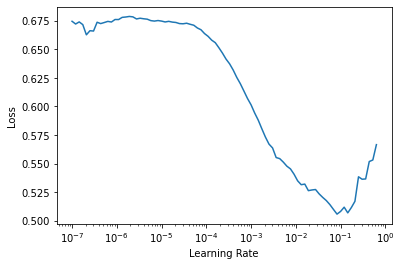

In [ ]:
learn.lr_find()

It seems fastai2 now outputs the learning rate where the loss is minimum (lr_min) and where it the steepest descent happens (lr_steep). We will use lr_steep, since very close to the minimum, the loss might explore very fast.

In [ ]:
learn.fine_tune(epochs=5,base_lr=0.0030199517495930195)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.421137,0.619258,0.224648,00:12


epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.268930,0.404398,0.628324,00:12
1,0.256598,0.368848,0.600270,00:11
2,0.224795,0.412724,0.589449,00:11
3,0.180614,0.343367,0.691162,00:11
4,0.141327,0.352587,0.697138,00:11


In [ ]:
learn.fine_tune(epochs=5, base_lr=0.0030199517495930195, wd = 1e-3)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.451600,0.671100,0.467447,00:11


epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.285510,0.514384,0.649861,00:10
1,0.253326,0.397750,0.607034,00:10
2,0.228361,0.352065,0.686294,00:11
3,0.176708,0.397056,0.654918,00:11
4,0.131396,0.396111,0.656745,00:11


In [ ]:
learn.predict(fps_df.iloc[0])

(   fp0  fp1  fp2  fp3  fp4  fp5  ...  fp1019  fp1020  fp1021  fp1022  fp1023  act
 0    1    2    1    1    2    2  ...       2       1       1       1       1    0
 
 [1 rows x 1025 columns], tensor(0), tensor([0.9917, 0.0083]))